# Tasks

For each of the hotels extract the text on the description (and possibly other text metadata) and do the following:
1. Pre-process the text by removing stop words and stemming. Customize your stopword list if needed.
2. Create two wordclouds before and after pre-processing for each city (a total of four). Comment on the changes in the wordclouds.

# 0. Packages

In [6]:
import pandas as pd
from nltk.tokenize import word_tokenize  # For tokenizing
from nltk.stem import PorterStemmer  # For stemming
from nltk.stem import LancasterStemmer  # For stemming
from nltk.stem.snowball import SnowballStemmer  # For stemming
from nltk.stem import WordNetLemmatizer  # For lemmatizing
from nltk.corpus import stopwords  # Stopwords list
import re  # For regex expressions
from pandarallel import pandarallel  # For parallelizing pandas row operations
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from typing import Union  # Allows setting as inputs of a function a set of options
import matplotlib.pyplot as plt  # To create word cloud
from wordcloud import WordCloud  # To create word cloud

# 1. Importing the data

In [ ]:
# # Original (cleaned) data 
# df_og = pd.read_csv('books_and_genres_tim_cleaned.csv')

# # Create a copy to have original dataset in memory, to avoid loading it again
# df = df_og.copy()

In [ ]:
# # Create and save a subsample of books to work with
# df_sample = df_og.sample(100)

# # Save to .csv
# df_sample.to_csv('books_and_genres_tim_cleaned_100sample.csv', index = False)

In [9]:
# Import sample of books
df_sample = pd.read_csv('books_and_genres_tim_cleaned_100sample.csv')

df_sample.head()

,title,text,genres,lang
0,the wreck,"Produced by Marilynda Fraser-Cunliffe, LN Yadd...","['mystery', 'adult', 'love', 'romance', 'myste...",en
1,the robbers,Produced by David Widger\n\n\n\n\n\n ...,"['american', 'amazon', 'non-fiction', 'economi...",en
2,on and near the delaware,Produced by David Widger\n\n\n\n\n\n ...,['mythology'],en
3,the scotch twins,Produced by Lynn Hill and Luana Rodriquez. HT...,"['middle-grade', 'classics', 'biography', 'fic...",en
4,epistle to the hebrews,"Produced by Colin Bell, Thomas Strong and the ...","['non-fiction', 'christian', 'fiction', 'colle...",en


# 2. Text preprocessing

In [128]:
# Initialize parallelization for pandas
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## 2.1. Tokenizing

Below, we tokenize the text and lowercase it.

In [129]:
def preprocess_lower(text, rm_stopwords = False, stopword_set = None):
    """
    Preprocess text by:
       - Converting to lowercase.
       - Removing punctuation.
       - Tokenizing.
       - Removing stopwords (optional).
    
    Returns:
        list: A list of tokens lowercased and without punctuation.
    """
    text_lower = text.lower()
    text_no_punct = re.sub(r'[^\w\s]', '', text_lower)
    tokens = word_tokenize(text_no_punct)
    # Remove stopwords if desired
    if rm_stopwords == True:
        tokens = [token for token in tokens if token not in stopword_set]
    # We return the whole string of tokens so that we can find n-grams later
    return " ".join(tokens)

In [130]:
# Tokenization of the first description (example)
first = preprocess_lower(dftm.iloc[0, 3], rm_stopwords = False, stopword_set = None)
print(f'Tokenized text, lowercased and with stopwords:\n{first}')

Tokenized text, lowercased and with stopwords:
situated in barcelona 14 km from llevant tembo barcelona features accommodation with an outdoor swimming pool private parking a fitness centre and a shared lounge 14 km from forum beach and 19 km from platja del litoral the property offers a terrace and a bar the accommodation provides a 24hour front desk airport transfers room service and free wifi throughout the property all rooms at the hotel are fitted with a seating area a flatscreen tv and a safety deposit box featuring a private bathroom with a shower and a hairdryer some units at tembo barcelona also feature a city view all guest rooms will provide guests with a fridge a buffet breakfast is available at the accommodation at tembo barcelona you will find a restaurant serving international cuisine vegetarian dairyfree and vegan options can also be requested there is an inhouse snack bar and guests can also make use of the business area port olimpic is 46 km from the hotel while sagra

Note that distances are not usable anymore, as we lose the decimals and, thus, relevant information.

In [131]:
dftm['description_lower'] = dftm['description'].parallel_apply(
    lambda row: preprocess_lower(text = row, rm_stopwords=False, stopword_set=None)
    )

# Alternative without parallelization
# for idx, row in dftm.iterrows():
#     dftm.at[idx, 'description_lower'] = preprocess_lower(
#       text=row['description'], rm_stopwords=False, stopword_set=None
#       )

In [132]:
dftm.head()

,hotel_name,city,short_description,description,description_lower
0,Tembo Barcelona,Barcelona,Queen Studio\nEntire studio • 1 bathroom • 27m...,"Situated in Barcelona, 1.4 km from Llevant, Te...",situated in barcelona 14 km from llevant tembo...
1,Pol & Grace Hotel,Barcelona,Double or Twin Room\nBeds: 1 double or 2 twins,Immerse yourself in the world of art at Pol & ...,immerse yourself in the world of art at pol gr...
2,NH Barcelona Diagonal Center,Barcelona,Standard Double or Twin Room\nBeds: 1 double o...,This design hotel is situated 15 minutes’ from...,this design hotel is situated 15 minutes from ...
3,Occidental Barcelona 1929,Barcelona,Superior Double Room\nBeds: 1 double or 2 twin...,Occidental Barcelona 1929 features a seasonal ...,occidental barcelona 1929 features a seasonal ...
4,BARCELONA GOTIC Guesthouse,Barcelona,Basic Twin Room with Shared Bathroom\n2 twin b...,"Set in a 19-th century building, right in Barc...",set in a 19th century building right in barcel...


## 2.2. Removing stop words

In [133]:
my_stop_words = set(stopwords.words('spanish') + stopwords.words('english'))
# Create set of custom stopwords
# custom_stopwords_alejandro = {
#     'barcelona', 'madrid', 'hotel', 'hostel', 'guest', 'room', 'accommodation',
#     'km', 'metres', 'away', 'minutes', 'walk', 'distance', 'located', 'situated',
#     'feature', 'unit', 'offer', 'include', 'units', 'bathroom', 'private', 
#     'available', 'desk', 'bathroom', 'private', 'available', 'apartment', 'house', 'tv', 'balcony',
#     'wifi', 'free wifi', 'apartments', 'popular', 'modern', 'stylish', 'service', 'access'
# }
my_custom_stopwords = {
    'barcelona', 'madrid', 'hotel', 'hostel', 'guest', 'room', 'accommodation',
    'km', 'metres', 'away', 'minutes', 'walk', 'distance', 'located', 'situated',
    'feature', 'unit', 'offer', 'include', 'units', 'bathroom', 'available', 
    'apartment', 'house', 'apartments', 'popular', 'modern', 'stylish', 'service', 'access',
    'also', 'features',
}
# Update stopwords
my_stop_words.update(my_custom_stopwords)

In [134]:
# Applying it to the first row (example)
first = preprocess_lower(dftm.iloc[0, 3], rm_stopwords = True, stopword_set = my_stop_words)
print(f'Tokenized text, lowercased and without stopwords:\n{first}')

Tokenized text, lowercased and without stopwords:
14 llevant tembo features outdoor swimming pool private parking fitness centre shared lounge 14 forum beach 19 platja litoral property offers terrace bar provides 24hour front desk airport transfers free wifi throughout property rooms fitted seating area flatscreen tv safety deposit box featuring private shower hairdryer tembo city view rooms provide guests fridge buffet breakfast tembo find restaurant serving international cuisine vegetarian dairyfree vegan options requested inhouse snack bar guests make use business area port olimpic 46 sagrada familia 48 property prat airport 17


In [135]:
dftm['description_lower_no_stop'] = dftm['description'].parallel_apply(
    lambda row: preprocess_lower(text = row, rm_stopwords=True, stopword_set=my_stop_words)
    )

In [136]:
dftm.head()

,hotel_name,city,short_description,description,description_lower,description_lower_no_stop
0,Tembo Barcelona,Barcelona,Queen Studio\nEntire studio • 1 bathroom • 27m...,"Situated in Barcelona, 1.4 km from Llevant, Te...",situated in barcelona 14 km from llevant tembo...,14 llevant tembo features outdoor swimming poo...
1,Pol & Grace Hotel,Barcelona,Double or Twin Room\nBeds: 1 double or 2 twins,Immerse yourself in the world of art at Pol & ...,immerse yourself in the world of art at pol gr...,immerse world art pol grace enjoying unique wa...
2,NH Barcelona Diagonal Center,Barcelona,Standard Double or Twin Room\nBeds: 1 double o...,This design hotel is situated 15 minutes’ from...,this design hotel is situated 15 minutes from ...,design 15 beach 22 business area barcelonas po...
3,Occidental Barcelona 1929,Barcelona,Superior Double Room\nBeds: 1 double or 2 twin...,Occidental Barcelona 1929 features a seasonal ...,occidental barcelona 1929 features a seasonal ...,occidental 1929 features seasonal outdoor swim...
4,BARCELONA GOTIC Guesthouse,Barcelona,Basic Twin Room with Shared Bathroom\n2 twin b...,"Set in a 19-th century building, right in Barc...",set in a 19th century building right in barcel...,set 19th century building right barcelonas old...


## 2.3. Normalization

### A. Stemming

In [137]:
def preprocess_stem(text, stemmer = 'porter'):
    """
    Preprocess text by applying stemming.
    Should just input a string which has been previously pre-processed, which at least removes
    the punctuation.

    Returns:
        str: A string of stemmed tokens separated by spaces.
    """

    tokens = text.split()  # Split input text based on whitespaces

    if stemmer == 'porter':
        stem_class = PorterStemmer()
    elif stemmer == 'lancaster':
        stem_class = LancasterStemmer()
    elif stemmer == 'snowball':
        stem_class = SnowballStemmer("english")
    else:
        print('Stemmer type not accepted. Choose "porter", "lancaster" or "snowball".')

    stemmed_tokens = [stem_class.stem(token) for token in tokens]

    return " ".join(stemmed_tokens)

In [138]:
# Applying it to the first row (example)
first_stemmed = preprocess_stem(text = first, stemmer = 'porter')
print(f'Stemmed text, previously lowercased and without stopwords:\n{first_stemmed}')

Stemmed text, previously lowercased and without stopwords:
14 llevant tembo featur outdoor swim pool privat park fit centr share loung 14 forum beach 19 platja litor properti offer terrac bar provid 24hour front desk airport transfer free wifi throughout properti room fit seat area flatscreen tv safeti deposit box featur privat shower hairdryer tembo citi view room provid guest fridg buffet breakfast tembo find restaur serv intern cuisin vegetarian dairyfre vegan option request inhous snack bar guest make use busi area port olimp 46 sagrada familia 48 properti prat airport 17


In [139]:
dftm['description_stemmed'] = dftm['description_lower_no_stop'].parallel_apply(
    lambda row: preprocess_stem(text = row, stemmer = 'porter')
    )

In [140]:
dftm.head()

,hotel_name,city,short_description,description,description_lower,description_lower_no_stop,description_stemmed
0,Tembo Barcelona,Barcelona,Queen Studio\nEntire studio • 1 bathroom • 27m...,"Situated in Barcelona, 1.4 km from Llevant, Te...",situated in barcelona 14 km from llevant tembo...,14 llevant tembo features outdoor swimming poo...,14 llevant tembo featur outdoor swim pool priv...
1,Pol & Grace Hotel,Barcelona,Double or Twin Room\nBeds: 1 double or 2 twins,Immerse yourself in the world of art at Pol & ...,immerse yourself in the world of art at pol gr...,immerse world art pol grace enjoying unique wa...,immers world art pol grace enjoy uniqu wall ca...
2,NH Barcelona Diagonal Center,Barcelona,Standard Double or Twin Room\nBeds: 1 double o...,This design hotel is situated 15 minutes’ from...,this design hotel is situated 15 minutes from ...,design 15 beach 22 business area barcelonas po...,design 15 beach 22 busi area barcelona pobl no...
3,Occidental Barcelona 1929,Barcelona,Superior Double Room\nBeds: 1 double or 2 twin...,Occidental Barcelona 1929 features a seasonal ...,occidental barcelona 1929 features a seasonal ...,occidental 1929 features seasonal outdoor swim...,occident 1929 featur season outdoor swim pool ...
4,BARCELONA GOTIC Guesthouse,Barcelona,Basic Twin Room with Shared Bathroom\n2 twin b...,"Set in a 19-th century building, right in Barc...",set in a 19th century building right in barcel...,set 19th century building right barcelonas old...,set 19th centuri build right barcelona old tow...


### B. Lemmatizing

In [141]:
def preprocess_lemmatize(text):
    """
    Preprocess text by applying stemming.
    Should just input a string which has been previously pre-processed, which at least removes
    the punctuation.

    Returns:
        str: A string of stemmed tokens separated by spaces.
    """

    tokens = text.split()  # Split input text based on whitespaces
    lemmatizer = WordNetLemmatizer()  # Initiallize lemmatizer
    lemmatized_text = []  # Initialize empty list to store lemmatized text
    for word in tokens:
        lemmatized_text.append(lemmatizer.lemmatize(word))

    return " ".join(lemmatized_text)

In [142]:
# Applying it to the first row (example)
first_lemmatized = preprocess_lemmatize(text = first)
print(f'Lemmatized text, previously lowercased and without stopwords:\n{first_lemmatized}')

Lemmatized text, previously lowercased and without stopwords:
14 llevant tembo feature outdoor swimming pool private parking fitness centre shared lounge 14 forum beach 19 platja litoral property offer terrace bar provides 24hour front desk airport transfer free wifi throughout property room fitted seating area flatscreen tv safety deposit box featuring private shower hairdryer tembo city view room provide guest fridge buffet breakfast tembo find restaurant serving international cuisine vegetarian dairyfree vegan option requested inhouse snack bar guest make use business area port olimpic 46 sagrada familia 48 property prat airport 17


In [143]:
dftm['description_lemmatized'] = dftm['description_lower_no_stop'].parallel_apply(
    lambda row: preprocess_lemmatize(text = row)
    )

In [144]:
dftm.head()

,hotel_name,city,short_description,description,description_lower,description_lower_no_stop,description_stemmed,description_lemmatized
0,Tembo Barcelona,Barcelona,Queen Studio\nEntire studio • 1 bathroom • 27m...,"Situated in Barcelona, 1.4 km from Llevant, Te...",situated in barcelona 14 km from llevant tembo...,14 llevant tembo features outdoor swimming poo...,14 llevant tembo featur outdoor swim pool priv...,14 llevant tembo feature outdoor swimming pool...
1,Pol & Grace Hotel,Barcelona,Double or Twin Room\nBeds: 1 double or 2 twins,Immerse yourself in the world of art at Pol & ...,immerse yourself in the world of art at pol gr...,immerse world art pol grace enjoying unique wa...,immers world art pol grace enjoy uniqu wall ca...,immerse world art pol grace enjoying unique wa...
2,NH Barcelona Diagonal Center,Barcelona,Standard Double or Twin Room\nBeds: 1 double o...,This design hotel is situated 15 minutes’ from...,this design hotel is situated 15 minutes from ...,design 15 beach 22 business area barcelonas po...,design 15 beach 22 busi area barcelona pobl no...,design 15 beach 22 business area barcelona pob...
3,Occidental Barcelona 1929,Barcelona,Superior Double Room\nBeds: 1 double or 2 twin...,Occidental Barcelona 1929 features a seasonal ...,occidental barcelona 1929 features a seasonal ...,occidental 1929 features seasonal outdoor swim...,occident 1929 featur season outdoor swim pool ...,occidental 1929 feature seasonal outdoor swimm...
4,BARCELONA GOTIC Guesthouse,Barcelona,Basic Twin Room with Shared Bathroom\n2 twin b...,"Set in a 19-th century building, right in Barc...",set in a 19th century building right in barcel...,set 19th century building right barcelonas old...,set 19th centuri build right barcelona old tow...,set 19th century building right barcelona old ...


## 2.4. Vectorizing

In this step, we just vectorize the already-preprocessed text (we could remove stopwords with `stop_words`, lowercase the text with `lowercase`, etc.). For more information, check: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

### Example (step by step)

In [145]:
cv = CountVectorizer(
    ngram_range = (1,3),  # Include unigrams, bigrams and trigrams
    min_df=0.05,  # Ignore terms appearing in less than 5% of the documents
    max_df=0.5,  # Ignore terms appearing in more than 50% of the documents 
    lowercase=False, 
    stop_words=None)

In [146]:
# Note that we can fit the count vectorizer with a pandas series
cv.fit(dftm['description_lower_no_stop'])
vectorized_text = cv.transform(dftm['description_lower_no_stop'])
# Return dense interpretation of sparse matrix
vectorized_text_dense = vectorized_text.todense()
# Print DTM size
print("Document-term matrix has size", vectorized_text.shape)
# Print terms extracted
terms = cv.get_feature_names_out()
print(terms)

Document-term matrix has size (906, 391)
['10' '100' '10minute' '11' '12' '13' '13 property' '14' '15' '16' '17'
 '18' '19' '20' '200' '24' '24hour' '24hour front' '24hour front desk'
 '24hour reception' '300' '400' '500' '5minute' '600' '700' '800' 'adolfo'
 'adolfo suarez' 'adolfo suarez madridbarajas' 'air' 'air conditioning'
 'air conditioning private' 'airconditioned' 'airconditioned rooms'
 'airport 12' 'airport 13' 'airport 14' 'airport 15' 'airport adolfo'
 'airport adolfo suarez' 'airport prat' 'airport shuttle' 'along'
 'along free' 'along free wifi' 'amenities' 'among' 'among facilities'
 'among facilities property' 'area' 'area flatscreen' 'area flatscreen tv'
 'around' 'art' 'atocha' 'atocha train' 'atocha train station'
 'attractions' 'balcony' 'bar' 'barajas' 'barcelonas' 'barceloneta' 'bars'
 'bars restaurants' 'bath' 'bathrooms' 'batllo' 'beach' 'bed' 'bed linen'
 'bed linen towels' 'bedroom' 'bedrooms' 'bernabéu' 'bernabéu stadium'
 'box' 'breakfast' 'bright' 'buffet'

- **`fit()`** learns the vocabulary from all text in the Series.
- **`transform()`** converts each row into a numerical representation based on that vocabulary.
- The output is a **sparse matrix**, which you convert to dense with `.todense()`.
- **`vectorized_text.shape`** gives the size of the document-term matrix:  
  - Rows = number of documents (i.e., rows in `dftm`)  
  - Columns = number of unique words in the vocabulary  
- **`cv.get_feature_names_out()`** returns the list of terms that were extracted.

In [147]:
# Calculate term frequencies (total counts across all documents)
term_frequencies = vectorized_text.sum(axis=0).A1  # Convert to 1D array

# Create a DataFrame for easier handling
df_terms_description = pd.DataFrame({
    'term': terms,
    'frequency': term_frequencies
})

# Sort the DataFrame by frequency in descending order
df_terms_description = df_terms_description.sort_values(by='frequency', ascending=False).reset_index(drop=True)

# Assign an ID from 1 (most frequent) to V (least frequent)
df_terms_description['id'] = df_terms_description.index + 1

# Display the top 10 terms as a sanity check
df_terms_description.head(10)

,term,frequency,id
0,plaza,551,1
1,equipped,472,2
2,gran,459,3
3,centre,437,4
4,guests,404,5
5,features,396,6
6,via,386,7
7,area,376,8
8,gran via,373,9
9,kitchen,368,10


### Function

In [148]:
def vectorizer(cv: Union[CountVectorizer, TfidfVectorizer], df: pd.DataFrame, column_text: str) -> pd.DataFrame:

    # Note that we can fit the count vectorizer with a pandas series
    cv.fit(df[column_text])
    vectorized_text = cv.transform(df[column_text])

    # Return dense interpretation of sparse matrix
    # vectorized_text_dense = vectorized_text.todense()

    # Print DTM size
    print("Document-term matrix has size", vectorized_text.shape)

    # Save extracted terms
    terms = cv.get_feature_names_out()

    # Calculate term frequencies (total counts across all documents)
    term_frequencies = vectorized_text.sum(axis=0).A1  # Convert to 1D array
    # Create a DataFrame for easier handling
    df_terms_description = pd.DataFrame({
        'term': terms,
        'frequency': term_frequencies
    })

    # Sort the DataFrame by frequency in descending order
    df_terms_description = df_terms_description.sort_values(by='frequency', ascending=False).reset_index(drop=True)

    # Assign an ID from 1 (most frequent) to V (least frequent)
    df_terms_description['id'] = df_terms_description.index + 1

    return df_terms_description

#### A. Usage with CountVectorizer

In [149]:
# Example usage

# Step 1: initialize the count vectorizer
cv_maxdf05 = CountVectorizer(
    ngram_range = (1,3),  # Include unigrams, bigrams and trigrams
    min_df=0.05,  # Ignore terms appearing in less than 5% of the documents
    max_df=0.5,  # Ignore terms appearing in more than 50% of the documents 
    lowercase=False, 
    stop_words=None)

# Step 2: execute the function with differentt preprocessed descriptions
df_terms_description_wostopwords = vectorizer(
    cv = cv_maxdf05, df = dftm, column_text='description_lower_no_stop'
    )
df_terms_description_stemmed = vectorizer(
    cv = cv_maxdf05, df = dftm, column_text='description_stemmed'
    )
df_terms_description_lemmatized = vectorizer(
    cv = cv_maxdf05, df = dftm, column_text='description_lemmatized'
    )

Document-term matrix has size (906, 391)
Document-term matrix has size (906, 397)
Document-term matrix has size (906, 392)


In [150]:
print(df_terms_description_wostopwords.head())
print(df_terms_description_stemmed.head())
print(df_terms_description_lemmatized.head())

       term  frequency  id
0     plaza        551   1
1  equipped        472   2
2      gran        459   3
3    centre        437   4
4    guests        404   5
     term  frequency  id
0  featur        557   1
1   plaza        551   2
2   equip        480   3
3    gran        459   4
4   centr        442   5
       term  frequency  id
0     plaza        551   1
1  equipped        472   2
2      gran        459   3
3    centre        442   4
4      area        414   5


#### B. Usage with TfidfVectorizer

According to the notebooks `session4_vectormath` and the one of the 3rd TA session (`vectorization_students_2025`), the way we can replicate the tf-idf function seen in class is by setting the following parameters: 

For more information, check https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html. 
- Setting the smoothing parameter to `True` may be useful for preventing zero divisions whenever there is a term that is included in the matrix but that isn't seen in any document.
- On the other hand, setting the parameter `sublinear_tf=True` is essential to replicate the idea of the regular tf-idf seen in class.

In [151]:
# Step 1: initialize the tfidf vectorizer
tfidf = TfidfVectorizer(
    lowercase=False, 
    sublinear_tf=True, 
    smooth_idf=False,
    ngram_range=(1,3),  # Include unigrams, bigrams and trigrams
    min_df=0.05,  # Ignore terms appearing in less than 5% of the documents
    max_df=0.5,  # Ignore terms appearing in more than 50% of the documents 
    )

# Step 2: execute the function with differentt preprocessed descriptions
df_tfidf_description_wostopwords = vectorizer(
    cv = tfidf, df = dftm, column_text='description_lower_no_stop'
    )
df_tfidf_description_stemmed = vectorizer(
    cv = tfidf, df = dftm, column_text='description_stemmed'
    )
df_tfidf_description_lemmatized = vectorizer(
    cv = tfidf, df = dftm, column_text='description_lemmatized'
    )

Document-term matrix has size (906, 391)
Document-term matrix has size (906, 397)
Document-term matrix has size (906, 392)


In [152]:
print(df_tfidf_description_wostopwords.head())
print(df_tfidf_description_stemmed.head())
print(df_tfidf_description_lemmatized.head())

     term  frequency  id
0   plaza  41.412942   1
1  centre  38.648616   2
2    gran  36.922249   3
3  guests  34.986454   4
4    city  34.724922   5
      term  frequency  id
0    plaza  40.723064   1
1   featur  39.437708   2
2    centr  37.903234   3
3     gran  36.542597   4
4  restaur  36.370702   5
         term  frequency  id
0       plaza  41.189439   1
1      centre  38.505938   2
2  restaurant  37.176171   3
3        gran  36.830909   4
4        area  36.340282   5


# 3. Wordclouds

Before and after pre-processing for each city.

Wordcloud references:
- https://pypi.org/project/wordcloud/
- Documentation: http://amueller.github.io/word_cloud/

In [166]:
# Function that creates a word cloud with a data frame of counts/relevance score
# as input

def create_wordcloud(df_terms_description: pd.DataFrame, width: int = 800, height: int = 400, 
                     background_color: str = "white", colormap: str = "viridis", title: str = None) -> None:
    """
    Generates and displays a word cloud from a DataFrame containing term frequencies.

    Parameters:
    -----------
    df_terms_description : pd.DataFrame
        A pandas DataFrame with at least two columns:
        - 'term': Contains words extracted from the text.
        - 'frequency': Contains the corresponding term frequency or importance score.

    width : int, optional (default=800)
        The width of the generated word cloud image, in pixels.

    height : int, optional (default=400)
        The height of the generated word cloud image, in pixels.

    background_color : str, optional (default="white")
        The background color of the word cloud. Common values: "white", "black", "gray".

    colormap : str, optional (default="viridis")
        The color map used for the word cloud. Examples: "plasma", "inferno", "cool", "magma".
        See Matplotlib colormaps for more options.

    Returns:
    --------
    None
        Displays the word cloud image using Matplotlib.
    
    """

    # Validate that the DataFrame has the required columns
    required_columns = {'term', 'frequency'}
    if not required_columns.issubset(df_terms_description.columns):
        raise ValueError(f"DataFrame must contain the columns: {required_columns}")

    # Convert DataFrame to dictionary {term: frequency}
    term_freq_dict = dict(zip(df_terms_description['term'], df_terms_description['frequency']))

    # Generate the word cloud
    wordcloud = WordCloud(width=width, height=height, 
                          background_color=background_color, colormap=colormap
                          ).generate_from_frequencies(term_freq_dict)

    # Display the word cloud
    plt.figure(figsize=(width / 100, height / 100))  # Convert pixels to inches for Matplotlib
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")  # Hide axis
    if title:
        plt.title(title, fontsize=14, fontweight='bold')
    plt.show

In [155]:
# Starting point: pre-processed texts from section 2.3
dftm.head()

,hotel_name,city,short_description,description,description_lower,description_lower_no_stop,description_stemmed,description_lemmatized
0,Tembo Barcelona,Barcelona,Queen Studio\nEntire studio • 1 bathroom • 27m...,"Situated in Barcelona, 1.4 km from Llevant, Te...",situated in barcelona 14 km from llevant tembo...,14 llevant tembo features outdoor swimming poo...,14 llevant tembo featur outdoor swim pool priv...,14 llevant tembo feature outdoor swimming pool...
1,Pol & Grace Hotel,Barcelona,Double or Twin Room\nBeds: 1 double or 2 twins,Immerse yourself in the world of art at Pol & ...,immerse yourself in the world of art at pol gr...,immerse world art pol grace enjoying unique wa...,immers world art pol grace enjoy uniqu wall ca...,immerse world art pol grace enjoying unique wa...
2,NH Barcelona Diagonal Center,Barcelona,Standard Double or Twin Room\nBeds: 1 double o...,This design hotel is situated 15 minutes’ from...,this design hotel is situated 15 minutes from ...,design 15 beach 22 business area barcelonas po...,design 15 beach 22 busi area barcelona pobl no...,design 15 beach 22 business area barcelona pob...
3,Occidental Barcelona 1929,Barcelona,Superior Double Room\nBeds: 1 double or 2 twin...,Occidental Barcelona 1929 features a seasonal ...,occidental barcelona 1929 features a seasonal ...,occidental 1929 features seasonal outdoor swim...,occident 1929 featur season outdoor swim pool ...,occidental 1929 feature seasonal outdoor swimm...
4,BARCELONA GOTIC Guesthouse,Barcelona,Basic Twin Room with Shared Bathroom\n2 twin b...,"Set in a 19-th century building, right in Barc...",set in a 19th century building right in barcel...,set 19th century building right barcelonas old...,set 19th centuri build right barcelona old tow...,set 19th century building right barcelona old ...


In [156]:
# We split the data frame into 2, one for each city
dftm_bcn = dftm[dftm['city'] == 'Barcelona']
dftm_mad = dftm[dftm['city'] == 'Madrid']

For creating the input for the word clouds, we use the `vectorizer` function created in section 2.4 above.

In [158]:
cv = CountVectorizer(
    ngram_range = (1,3),  # Include unigrams, bigrams and trigrams
    min_df=0.05,  # Ignore terms appearing in less than 5% of the documents
    max_df=0.5,  # Ignore terms appearing in more than 50% of the documents 
    lowercase=False, 
    stop_words=None)
tfidf = TfidfVectorizer(
    lowercase=False, 
    sublinear_tf=True, 
    smooth_idf=False,
    ngram_range=(1,3),  # Include unigrams, bigrams and trigrams
    min_df=0.05,  # Ignore terms appearing in less than 5% of the documents
    max_df=0.5,  # Ignore terms appearing in more than 50% of the documents 
    )

### 3.1 World Cloud Before Pre-Processing

In [161]:
# Vectorize with no preprocessing at all
df_terms_description_nopre_bcn = vectorizer(
    cv = cv, df = dftm_bcn, column_text='description'
    )
df_terms_description_nopre_mad = vectorizer(
    cv = cv, df = dftm_mad, column_text='description'
    )

# Tfidf with no preprocessing
df_tfidf_description_nopre_bcn = vectorizer(
    cv = tfidf, df = dftm_bcn, column_text='description'
    )
df_tfidf_description_nopre_mad = vectorizer(
    cv = tfidf, df = dftm_mad, column_text='description'
    )

Document-term matrix has size (388, 903)
Document-term matrix has size (518, 936)
Document-term matrix has size (388, 903)
Document-term matrix has size (518, 936)


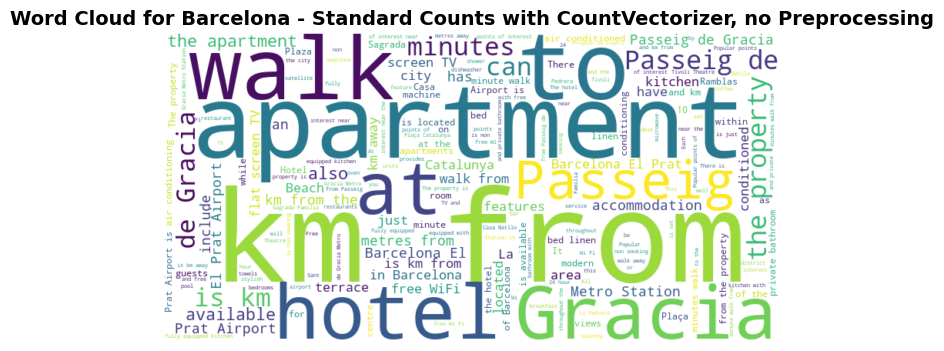

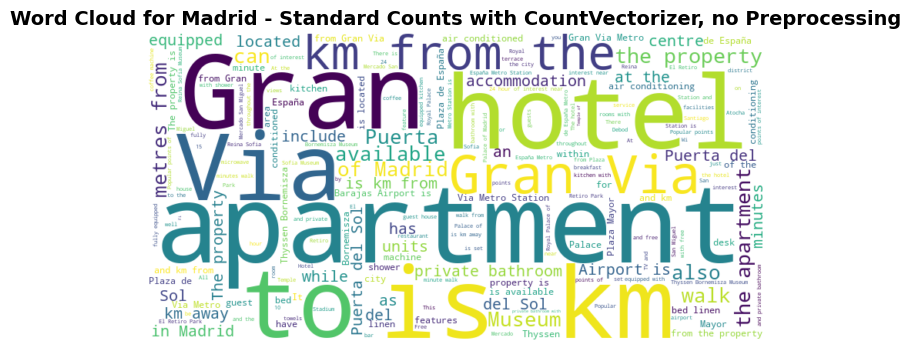

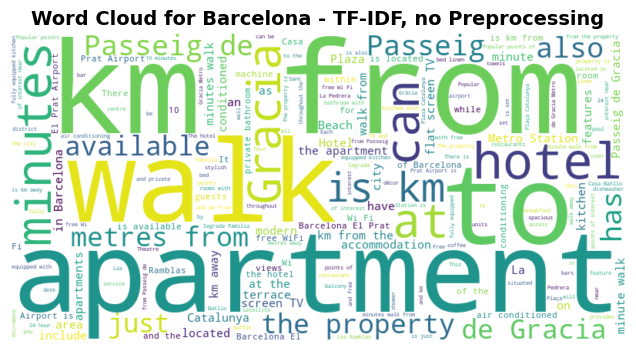

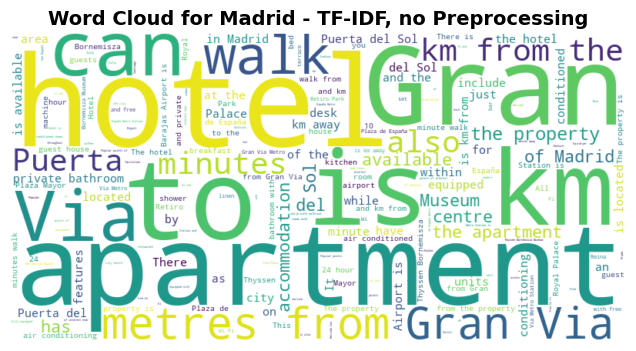

In [167]:
title_count_noprepr_bcn = 'Word Cloud for Barcelona - Standard Counts with CountVectorizer, no Preprocessing'
title_tfidf_noprepr_bcn = 'Word Cloud for Barcelona - TF-IDF, no Preprocessing'
title_count_noprepr_mad = 'Word Cloud for Madrid - Standard Counts with CountVectorizer, no Preprocessing'
title_tfidf_noprepr_mad = 'Word Cloud for Madrid - TF-IDF, no Preprocessing'

# Word clouds with vectorizing
create_wordcloud(df_terms_description = df_terms_description_nopre_bcn, 
                 width = 800, height = 400, background_color = "white", 
                 colormap = "viridis", 
                 title = title_count_noprepr_bcn)
create_wordcloud(df_terms_description = df_terms_description_nopre_mad, 
                 width = 800, height = 400, background_color = "white", 
                 colormap = "viridis", 
                 title = title_count_noprepr_mad)

# Word clouds with tfidf
create_wordcloud(df_terms_description = df_tfidf_description_nopre_bcn, 
                 width = 800, height = 400, background_color = "white", 
                 colormap = "viridis", 
                 title = title_tfidf_noprepr_bcn)
create_wordcloud(df_terms_description = df_tfidf_description_nopre_mad, 
                 width = 800, height = 400, background_color = "white", 
                 colormap = "viridis", 
                 title = title_tfidf_noprepr_mad)

### 3.2. Word clouds After Stopwords Removal

In [170]:
df_terms_description_nostop_bcn = vectorizer(
    cv = cv, df = dftm_bcn, column_text='description_lower_no_stop'
    )
df_terms_description_nostop_mad = vectorizer(
    cv = cv, df = dftm_mad, column_text='description_lower_no_stop'
    )

# Tfidf with no preprocessing
df_tfidf_description_nostop_bcn = vectorizer(
    cv = tfidf, df = dftm_bcn, column_text='description_lower_no_stop'
    )
df_tfidf_description_nostop_mad = vectorizer(
    cv = tfidf, df = dftm_mad, column_text='description_lower_no_stop'
    )

Document-term matrix has size (388, 402)
Document-term matrix has size (518, 362)
Document-term matrix has size (388, 402)
Document-term matrix has size (518, 362)


The number of terms has been reduced significantly!

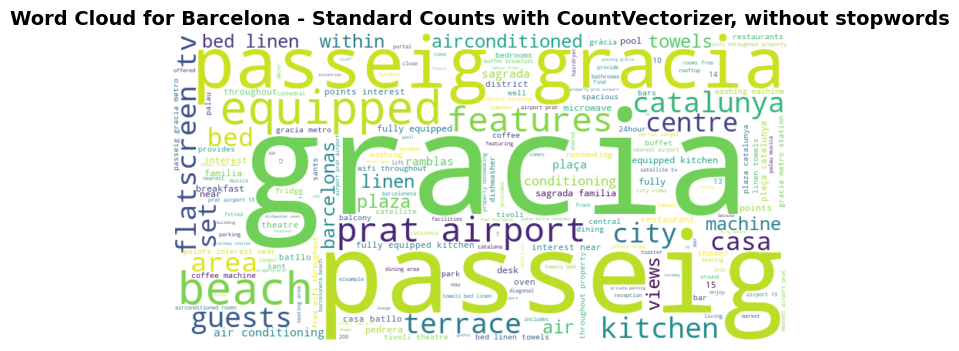

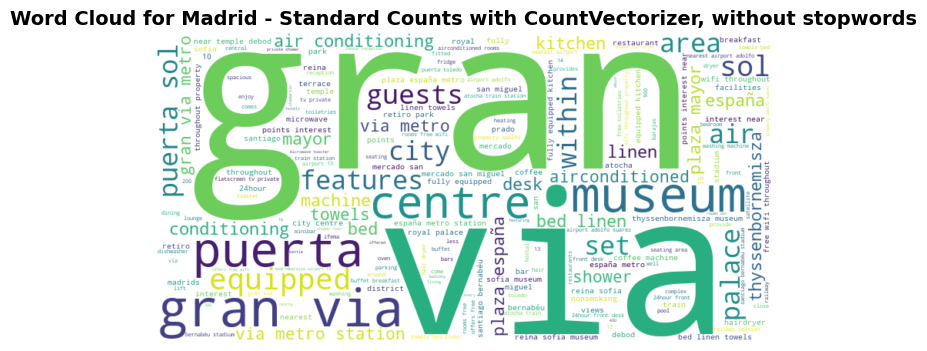

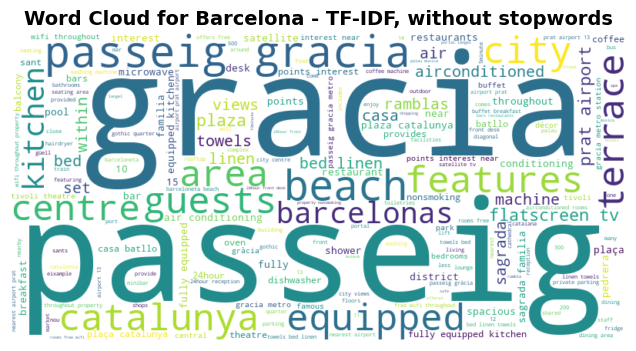

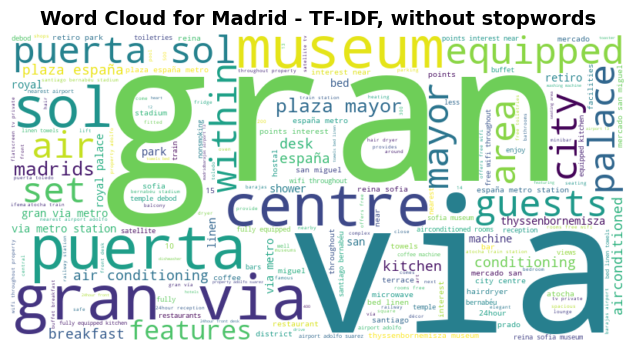

In [172]:
title_count_nostopwords_bcn = 'Word Cloud for Barcelona - Standard Counts with CountVectorizer, without stopwords'
title_tfidf_nostopwords_bcn = 'Word Cloud for Barcelona - TF-IDF, without stopwords'
title_count_nostopwords_mad = 'Word Cloud for Madrid - Standard Counts with CountVectorizer, without stopwords'
title_tfidf_nostopwords_mad = 'Word Cloud for Madrid - TF-IDF, without stopwords'

# Word clouds with vectorizing
create_wordcloud(df_terms_description = df_terms_description_nostop_bcn, 
                 width = 800, height = 400, background_color = "white", 
                 colormap = "viridis", 
                 title = title_count_nostopwords_bcn)
create_wordcloud(df_terms_description = df_terms_description_nostop_mad, 
                 width = 800, height = 400, background_color = "white", 
                 colormap = "viridis", 
                 title = title_count_nostopwords_mad)

# Word clouds with tfidf
create_wordcloud(df_terms_description = df_tfidf_description_nostop_bcn, 
                 width = 800, height = 400, background_color = "white", 
                 colormap = "viridis", 
                 title = title_tfidf_nostopwords_bcn)
create_wordcloud(df_terms_description = df_tfidf_description_nostop_mad, 
                 width = 800, height = 400, background_color = "white", 
                 colormap = "viridis", 
                 title = title_tfidf_nostopwords_mad)

### 3.3. World Cloud After Stemming

In [173]:
df_terms_description_stem_bcn = vectorizer(
    cv = cv, df = dftm_bcn, column_text='description_stemmed'
    )
df_terms_description_stem_mad = vectorizer(
    cv = cv, df = dftm_mad, column_text='description_stemmed'
    )

# Tfidf with no preprocessing
df_tfidf_description_stem_bcn = vectorizer(
    cv = tfidf, df = dftm_bcn, column_text='description_stemmed'
    )
df_tfidf_description_stem_mad = vectorizer(
    cv = tfidf, df = dftm_mad, column_text='description_stemmed'
    )

Document-term matrix has size (388, 403)
Document-term matrix has size (518, 368)
Document-term matrix has size (388, 403)
Document-term matrix has size (518, 368)


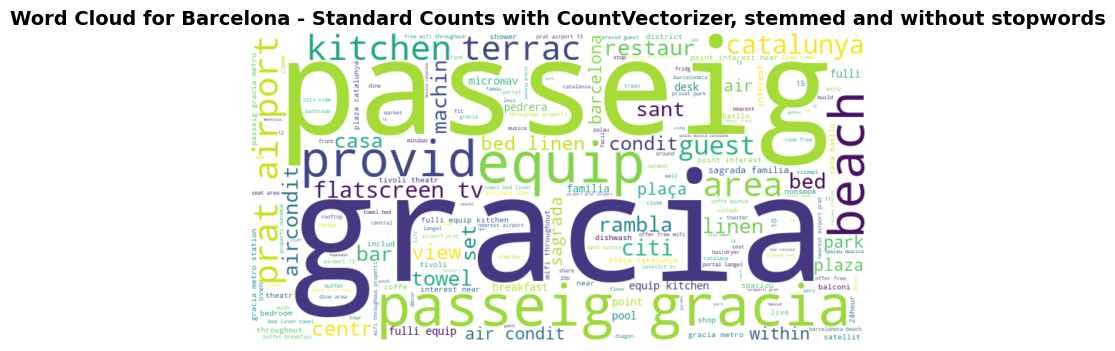

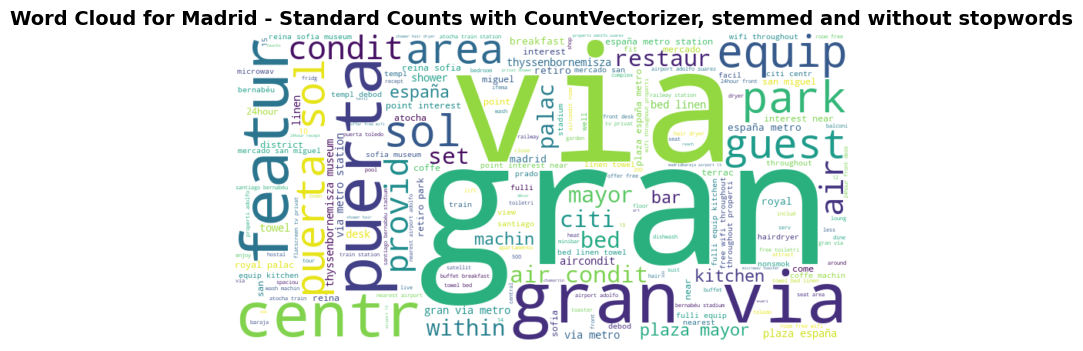

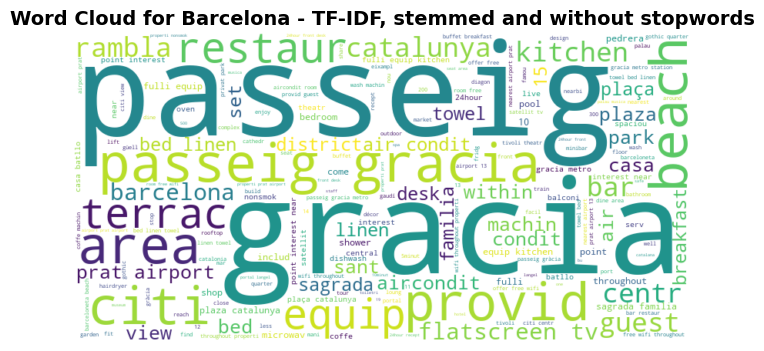

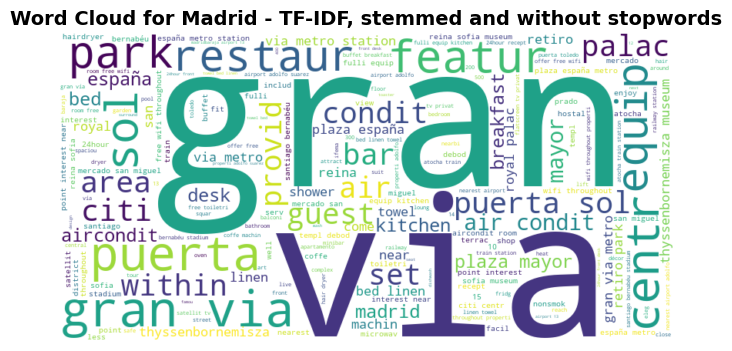

In [174]:
title_count_stem_bcn = 'Word Cloud for Barcelona - Standard Counts with CountVectorizer, stemmed and without stopwords'
title_tfidf_stem_bcn = 'Word Cloud for Barcelona - TF-IDF, stemmed and without stopwords'
title_count_stem_mad = 'Word Cloud for Madrid - Standard Counts with CountVectorizer, stemmed and without stopwords'
title_tfidf_stem_mad = 'Word Cloud for Madrid - TF-IDF, stemmed and without stopwords'

# Word clouds with vectorizing
create_wordcloud(df_terms_description = df_terms_description_stem_bcn, 
                 width = 800, height = 400, background_color = "white", 
                 colormap = "viridis", 
                 title = title_count_stem_bcn)
create_wordcloud(df_terms_description = df_terms_description_stem_mad, 
                 width = 800, height = 400, background_color = "white", 
                 colormap = "viridis", 
                 title = title_count_stem_mad)

# Word clouds with tfidf
create_wordcloud(df_terms_description = df_tfidf_description_stem_bcn, 
                 width = 800, height = 400, background_color = "white", 
                 colormap = "viridis", 
                 title = title_tfidf_stem_bcn)
create_wordcloud(df_terms_description = df_tfidf_description_stem_mad, 
                 width = 800, height = 400, background_color = "white", 
                 colormap = "viridis", 
                 title = title_tfidf_stem_mad)

# 4. Exporting

Now, we could export the counts of the terms or the relative importance using *tf-idf*.